<a href="https://colab.research.google.com/github/JayNguyen-123/Swiss_Roll_Diffusion/blob/main/Diffusion_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Denoising Diffusion Probabilitic Model

 There are four steps to be implemented:
- Forward process
- Neural network for training
- Training
- Sampling



In [19]:
# Prepare Datasets
from sklearn.datasets import make_swiss_roll

def create_original_data(sample_num, noise_std):
  x , _ = make_swiss_roll(n_samples=sample_num, noise=noise_std)
  # extract x and z axis
  x = x[:, [0, 2]]
  # normalize value
  x = (x - x.mean()) / x.std()

  return x



### Forward Process
- The forward process of adding Gaussian noise to the input data is expressed by the following equation. Diffusion model gradually adds Gaussian noise to the data according to a variance schedule beta b1...bt

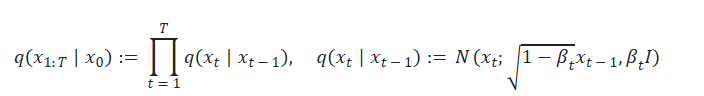

- A notable property of the forward process is that it admits sampling
x
t
, at an arbitrary timestep
t
 in closed form: using the notation
α
t
:=
1
−
β
t
 and
α
t
¯
=
∏
s
=
1
t
α
s
, we have

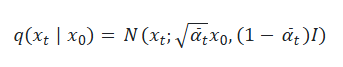

Thus, we can get
x
t
 by using a reparameterization trick.

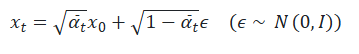



In [20]:
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import FuncAnimation



In [21]:
def calculate_parameters(diffusion_steps, min_beta, max_beta):
    step = (max_beta - min_beta) / diffusion_steps
    beta_ts = torch.arange(min_beta, max_beta + step, step)

    alpha_ts = 1 - beta_ts
    bar_alpha_ts = torch.cumprod(alpha_ts, dim=0)

    return beta_ts, alpha_ts, bar_alpha_ts


In [22]:
def calculate_data_at_certain_time(x_0, bar_alpha_ts, t):
    eps = torch.randn(size=x_0.shape)
    noised_x_t = (
        torch.sqrt(bar_alpha_ts[t]) * x_0 + torch.sqrt(1 - bar_alpha_ts[t]) * eps
    )

    return noised_x_t, eps


In [23]:
def create_forward_process_animation(x, diffusion_steps, min_beta, max_beta, save_path):
    X = torch.tensor(x, dtype=torch.float32)
    beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(
        diffusion_steps, min_beta, max_beta
    )
    fig, ax = plt.subplots(figsize=(6, 6))
    scatter = ax.scatter([], [], alpha=0.1, s=1)

    def init():
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Forward Process")
        return (scatter,)

    def update(t):
        noised_x_t, eps = calculate_data_at_certain_time(X, bar_alpha_ts, t)
        # Update scatter plot
        scatter.set_offsets(noised_x_t)
        ax.set_title(f"Forward Process - Step {t}/{diffusion_steps}")
        return (scatter,)

    # Create animation
    anim = FuncAnimation(fig, update, frames=diffusion_steps, init_func=init, blit=True)

    # Save animation as video
    anim.save(save_path, writer="pillow", fps=10)
    plt.close(fig)
    print("Finish saving gif file: ", save_path)




In [24]:
if __name__=="__main__":
  sample_num = 100000
  noise_std = 0.5
  x = create_original_data(sample_num, noise_std)
  diffusion_steps=50
  min_beta = 1e-4
  max_beta = 0.02
  save_path = "/content/sample_data/forward_process.gif"
  create_forward_process_animation(x, diffusion_steps, min_beta, max_beta, save_path)

Finish saving gif file:  /content/sample_data/forward_process.gif


### Neural Network for Training
- Original paper uses U-Net backbone, but I used simple neural network for training this time because it is enough in this data. It has 4 hidden layers and use ReLU as an activation function.

In [25]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        input_data = torch.hstack([x, t])
        return self.net(input_data)



In [26]:
if __name__ == "__main__":
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print("Using {0} device".format(device))
    model = Network().to(device)
    print(model)


Using cuda device
Network(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Training
- In reverse process, we calculate
x
t
−
1
 from
x
t
 and timestep
t
 by normal distribution.

x
t
−
1
∼
N
(
μ
θ
(
x
t
,
t
)
,
Σ
t
)

The variance is fixed, so we need to predict
μ
θ
(
x
t
,
t
)
.
μ
θ
(
x
t
,
t
)
 can be rewritten as follows by simplifying equations. If you want to know the details of that, please check derivation of loss function section.

μ
θ
(
x
t
,
t
)
=
1
α
t
(
x
t
−
β
t
1
−
α
t
¯
ϵ
θ
(
x
t
,
t
)
)

Therefore, we train
ϵ
 during training, loss function is as follows. If you want to know the details of that, please check derivation of loss function section.

L
s
i
m
p
l
e
:=
E
t
,
x
0
,
ϵ
[
|
ϵ
−
ϵ
θ
(
α
t
¯
x
0
+
1
−
α
t
¯
ϵ
,
t
)
|
2
]

 - Below training algorithms of original paper.

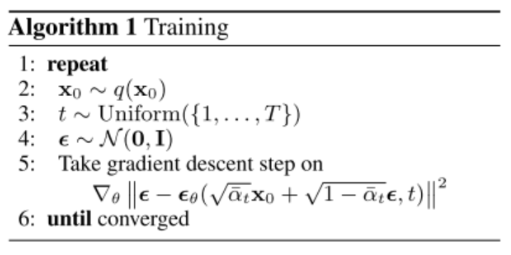


In [28]:
# Training
import torch
import torch.nn as nn

def train(data, batch_size, device, epochs, diffusion_steps, min_beta, max_beta, learning_rate, output_model_path):
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
  model = Network().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_fn = nn.MSELoss()

  beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(diffusion_steps, min_beta, max_beta )

  for epoch in range(epochs):
    count = 0
    epoch_loss = 0
    for x in data_loader:
      random_time_step = torch.randint(0, diffusion_steps, size=[len(x), 1])
      noise_x_t, eps = calculate_data_at_certain_time(x, bar_alpha_ts, random_time_step)
      predicted_eps = model.forward(noise_x_t.to(device), random_time_step.to(device))
      loss = loss_fn(predicted_eps, eps.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      count += 1

    print("Epoch {0}, Loss = {1}".format(epoch, round(epoch_loss / count, 5)))

  print("Finished Training!")
  torch.save(model.state_dict(), output_model_path)
  print("Save model: ", output_model_path)




In [33]:
if __name__ == "__main__":

  device = (
      "cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
  print("Using {0} device".format(device))

  sample_num = 100000
  noise_std = 0.5
  x = create_original_data(sample_num, noise_std)
  data = torch.tensor(x, dtype=torch.float32)
  batch_size = 128
  epochs = 30
  diffusion_steps = 50
  min_beta = 1e-4
  max_beta = 0.02
  learning_rate = 1e-3
  output_model_path = "/content/sample_data/diffusion_model.pth"

  train(
      data,
      batch_size,
      device,
      epochs,
      diffusion_steps,
      min_beta,
      max_beta,
      learning_rate,
      output_model_path,
  )


Using cuda device
Epoch 0, Loss = 0.85925
Epoch 1, Loss = 0.79928
Epoch 2, Loss = 0.77255
Epoch 3, Loss = 0.7479
Epoch 4, Loss = 0.73031
Epoch 5, Loss = 0.72284
Epoch 6, Loss = 0.71251
Epoch 7, Loss = 0.71287
Epoch 8, Loss = 0.71368
Epoch 9, Loss = 0.70661
Epoch 10, Loss = 0.70594
Epoch 11, Loss = 0.70064
Epoch 12, Loss = 0.70271
Epoch 13, Loss = 0.70167
Epoch 14, Loss = 0.70399
Epoch 15, Loss = 0.70024
Epoch 16, Loss = 0.7012
Epoch 17, Loss = 0.70176
Epoch 18, Loss = 0.69683
Epoch 19, Loss = 0.70231
Epoch 20, Loss = 0.70104
Epoch 21, Loss = 0.69817
Epoch 22, Loss = 0.69951
Epoch 23, Loss = 0.70066
Epoch 24, Loss = 0.70043
Epoch 25, Loss = 0.6941
Epoch 26, Loss = 0.70031
Epoch 27, Loss = 0.69788
Epoch 28, Loss = 0.69537
Epoch 29, Loss = 0.69553
Finished Training!
Save model:  /content/sample_data/diffusion_model.pth


### Sampling
- To sample
x
t
−
1
∼
p
θ
(
x
t
−
1
|
x
t
)
 is to compute below equation. It is used reparameterization trick.

x
t
−
1
=
1
α
t
(
x
t
−
β
t
1
−
α
t
¯
ϵ
θ
(
x
t
,
t
)
)
+
σ
t
z
,
(
z
∼
N
(
0
,
I
)
)

I followed below sampling algorithms of original paper. We initialize
x
T
 with a random value, and with
x
t
 and
t
 as inputs, the neural network output
ϵ
, so we use that value to calculate
x
t
−
1
. This is repeated until
x
0
 is calculated.

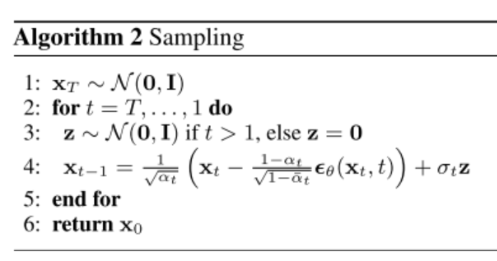


In [39]:
def sampling(model_path, sample_num, diffusion_steps, min_beta, max_beta):
    model = Network()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    with torch.no_grad():
        x_init = torch.randn(size=(sample_num, 2))
        beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(
            diffusion_steps, min_beta, max_beta
        )
        denoised_x = torch.zeros((diffusion_steps, x_init.shape[0], x_init.shape[1]))
        denoised_x[-1] = x_init
        for t in range(diffusion_steps - 1, 0, -1):
            if t > 1:
                z = torch.randn(x_init.shape)
            else:
                z = 0
            ts = torch.full((x_init.shape[0], 1), t)
            mu = (
                1
                / torch.sqrt(alpha_ts[t])
                * (
                    (
                        denoised_x[t]
                        - (1 - alpha_ts[t])
                        / torch.sqrt(1 - bar_alpha_ts[t])
                        * model.forward(denoised_x[t], ts)
                    )
                )
            )
            denoised_x[t - 1] = mu + torch.sqrt(beta_ts[t]) * z

    return denoised_x



In [40]:
def create_sampling_animation(denoised_x, diffusion_steps, save_path):
    fig, ax = plt.subplots(figsize=(6, 6))
    scatter = ax.scatter([], [], alpha=0.1, s=1)

    def init():
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Sampling")
        return (scatter,)

    def update(rev_t):
        # Update scatter plot
        t = diffusion_steps - 1 - rev_t
        scatter.set_offsets(denoised_x[t])
        ax.set_title(f"Sampling - Step {t}/{diffusion_steps}")
        return (scatter,)

    # Create animation
    anim = FuncAnimation(fig, update, frames=diffusion_steps, init_func=init, blit=True)
    # Save animation as video
    anim.save(save_path, writer="pillow", fps=10)
    plt.close(fig)
    print("Finish saving gif file: ", save_path)



In [41]:
if __name__=="__main__":
  model_path = "/content/sample_data/diffusion_model.pth"
  sample_num = 100000
  diffusion_steps = 50
  min_beta = 1e-4
  max_beta = 0.02
  denoised_x = sampling(model_path, sample_num, diffusion_steps, min_beta, max_beta)
  save_path = "/content/sample_data/forward_process.gif"
  create_sampling_animation(denoised_x, diffusion_steps, save_path)


Finish saving gif file:  /content/sample_data/forward_process.gif
